# **Pairwise Sequence Alignment**

# The Needleman-Wunsch Algorithm

The Needleman-Wunsch algorithm finds the optimal *global* alignment (end-to-end) between two sequences.
It consists of the following steps:

1. Construct the grid
2. Choose a scoring system (here we use the original scoring system assigning a score $s$ of 1 to a match, a score $s$ of -1 to a mismatch, and a score $d$ of -1 to a gap/indel)
3. Fill in the scoring matrix $F$ (and construct the pointer matrix on the way)
4. Use the pointer matrix to perform a traceback to recover the optimal warping path

The scores in the scoring matrix $F$ are computed using the already existing scores in the left, top-left, and top cells:

$$
F(i,j)=\max
\begin{cases}
    F(i-1,j-1)+s(x_i,y_i),\\
    F(i-1,j)+d,\\
    F(i,j-1)+d.
\end{cases}
$$

The following image illustrates the scoring and pointer matrices.

<img src="images/nw_matrix.png" width="500" />

We can use the `make_align()` function from our `alignment` module to generate an `align()` function that performs the Needleman-Wunsch algorithm.

In [10]:
import alignment as aln

x = "GATTACA"
y = "CATACCCA"

align = aln.make_align(mode="global")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

We can also plot the alignment together with the scoring matrix:

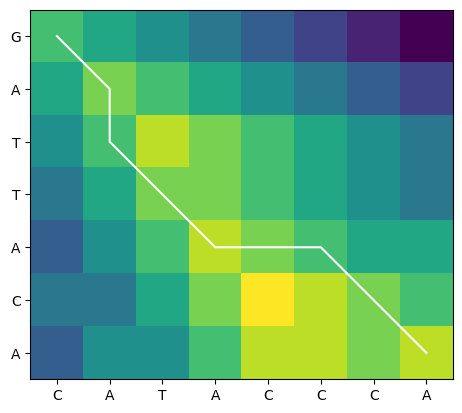

In [11]:
import matplotlib.pyplot as plt  # type: ignore

plt.imshow(X=scoring_mat)
plt.plot(warp_path_y, warp_path_x, "w")
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.show()

# The Smith-Waterman Algorithm

The Smith-Waterman algorithm finds the optimal *local* alignment between two sequences.
It is a variation of the Needleman-Wunsch algorithm.

The three main differences are:

|                | Smith-Waterman algorithm                                | Needleman-Wunsch algorithm                                                 |
|----------------|---------------------------------------------------------|----------------------------------------------------------------------------|
| Initialization | First row/column = 0                                    | First row/column subject to gap penalty                                    |
| Scoring        | Negative scores are set to 0                            | Scores can be negative                                                     |
| Traceback      | Begin with the highest score, end when 0 is encountered | Begin with the cell at the lower right of the matrix, end at top left cell |

Again, with our `alignment` module, we can perform the local alignment between the sequences `GATACCA` and `NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN`.

Multiple possible traceback starts: [ 5 16], [ 7 17]
Chose random traceback start from choices: [ 7 17]


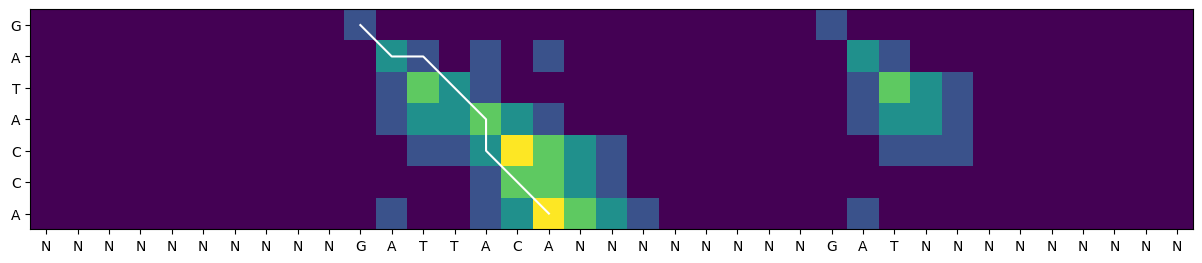

In [12]:
x = "GATACCA"
y = "NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN"

align = aln.make_align(mode="local")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

plt.figure(figsize=(15, 8))
plt.imshow(X=scoring_mat)
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.plot(warp_path_y, warp_path_x, "w")
plt.show()

# Read Alignment

We can also simulate the alignment of many reads originating from e.g., a bulk DNA sequencing experiment.

##### ❓ Sampling reads from a reference sequence

Simulate the generation of a number of reads, by sampling 5 reads from the reference sequence `GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA`.

In [13]:
import random

reference_sequence = "GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA"

n_reads = 20
min_read_len = 15
max_read_len = 25

reads = []

while len(reads) < n_reads:
    range_acquired = False
    while not range_acquired:
        start_position = random.randrange(len(reference_sequence))
        end_position = random.randrange(len(reference_sequence))
        if start_position > end_position:
            continue
        range_len = end_position - start_position + 1
        if range_len < min_read_len or range_len > max_read_len:
            continue
        range_acquired = True
        read = reference_sequence[start_position : (end_position + 1)]
        reads.append(read)

print(reads)

['AAATAGTAAATCCAT', 'ATCGATCAAATAGTAAAT', 'GATCAAATAGTAAATCCA', 'AATCCATTTGTTCAACTCA', 'ATAGTAAATCCATTTGTTCAA', 'TCAAAGCAGTATCGATCAAATAG', 'AAATAGTAAATCCATT', 'GTAAATCCATTTGTTCAACT', 'ATCAAATAGTAAATCCAT', 'AAAGCAGTATCGATCAA', 'ATAGTAAATCCATTTGTTCAACTCA', 'AAGCAGTATCGATCA', 'TCAAAGCAGTATCGATCAAATAG', 'ATCGATCAAATAGTAAATCC', 'ATCCATTTGTTCAACTCACAGT', 'AATAGTAAATCCATTTGTTCAA', 'ATCGATCAAATAGTAA', 'TAAATCCATTTGTTCAA', 'GATTTGGGGTTCAAAG', 'TTTGGGGTTCAAAGCAGTATCGATC']


##### ❓ Adding noise to the sampled reads

Add some noise to the sampled reads.

In [14]:
def add_noise(read: str, noiselessness: int = 4) -> tuple[str, int]:
    """Add noise to a read."""
    choices = ["A", "C", "G", "T"]
    n_noisy_bases = 0
    noisy_read = ""
    for base in read:
        if not random.randrange(noiselessness):
            noisy_read += random.choice(seq=[c for c in choices if c != base])
            n_noisy_bases += 1
        else:
            noisy_read += base
    return noisy_read, n_noisy_bases


noisy_reads = []
for read in reads:
    noisy_read, n_noisy_bases = add_noise(read=read, noiselessness=3)
    print(f"Added {n_noisy_bases:2} noisy base(s): {read:10s} -> {noisy_read:10s}")
    noisy_reads.append(noisy_read)

Added  6 noisy base(s): AAATAGTAAATCCAT -> AATAAGTAAAGCTGG
Added  6 noisy base(s): ATCGATCAAATAGTAAAT -> ATCAAGGGAGTAGTAAAC
Added  7 noisy base(s): GATCAAATAGTAAATCCA -> GATCGACAAGTGGGTGCA
Added  8 noisy base(s): AATCCATTTGTTCAACTCA -> AATCAATAGGGACCTCTGA
Added  6 noisy base(s): ATAGTAAATCCATTTGTTCAA -> GTAGTCGATGCTTTCGTTCAA
Added 10 noisy base(s): TCAAAGCAGTATCGATCAAATAG -> TTGCAGAAGTGTTGATACAACAA
Added  4 noisy base(s): AAATAGTAAATCCATT -> AGATATTAAATACATA
Added  7 noisy base(s): GTAAATCCATTTGTTCAACT -> ATAAATCCGTTGTTCCTTCT
Added  8 noisy base(s): ATCAAATAGTAAATCCAT -> AACATACACAAGATGCTT
Added  4 noisy base(s): AAAGCAGTATCGATCAA -> TCAGCCGTATCGAACAA
Added  7 noisy base(s): ATAGTAAATCCATTTGTTCAACTCA -> AGAGTAAATCATTTGGTTAAGATCA
Added  8 noisy base(s): AAGCAGTATCGATCA -> CAGCATTTCGCTTAA
Added  8 noisy base(s): TCAAAGCAGTATCGATCAAATAG -> TCATTGGGGTTTCCATCTAGTAG
Added  7 noisy base(s): ATCGATCAAATAGTAAATCC -> TTCGATCAAGTGTGAAATTT
Added  5 noisy base(s): ATCCATTTGTTCAACTCACAGT -> CTACATCT

##### ❓ Aligning reads

Use the `make_align()` function from the `alignment` module to generate an `align()` function to align the noisy reads locally to the reference sequence.

Multiple possible traceback starts: [10 37], [12 39]
Chose random traceback start from choices: [12 39]
Read                      : AATAAGTAAAGCTGG
Mapping position (0-based): 28
Aligned read              : AATAAGTAAAGC
Aligned read w/o gaps     : AATAAGTAAAGC
Number of clipped bases   : 3
Reference subsequence     : AATAGTAAATC


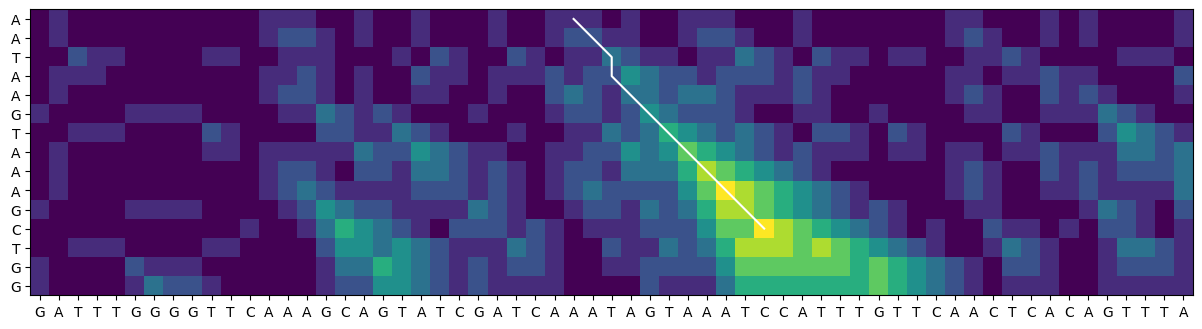

Multiple possible traceback starts: [17 37], [18 39]
Chose random traceback start from choices: [18 39]
Read                      : ATCAAGGGAGTAGTAAAC
Mapping position (0-based): 24
Aligned read              : ATCAAGGGAGTAGTAAA-C
Aligned read w/o gaps     : ATCAAGGGAGTAGTAAAC
Number of clipped bases   : 0
Reference subsequence     : ATCAAATAGTAAATC


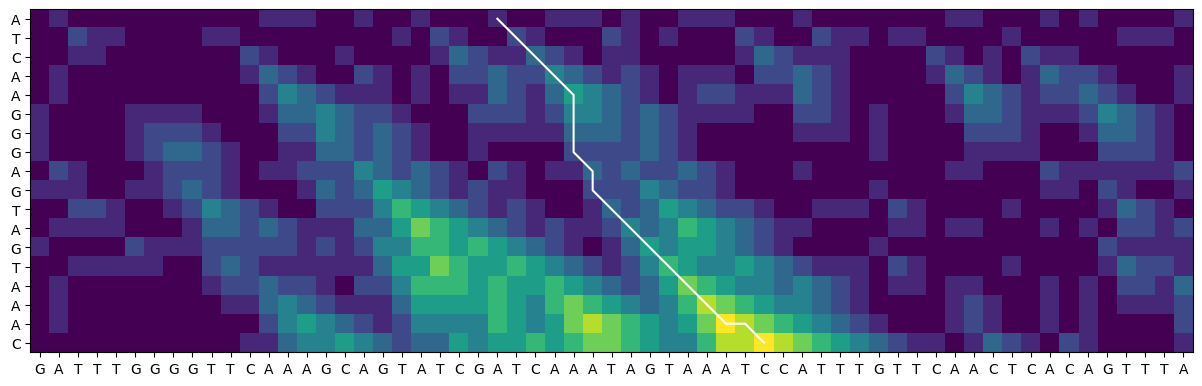

Multiple possible traceback starts: [ 9 29], [11 31], [12 33], [13 33], [15 34]
Chose random traceback start from choices: [ 9 29]
Read                      : GATCGACAAGTGGGTGCA
Mapping position (0-based): 20
Aligned read              : ATCGA-CAA
Aligned read w/o gaps     : ATCGACAA
Number of clipped bases   : 10
Reference subsequence     : ATCGATCAA


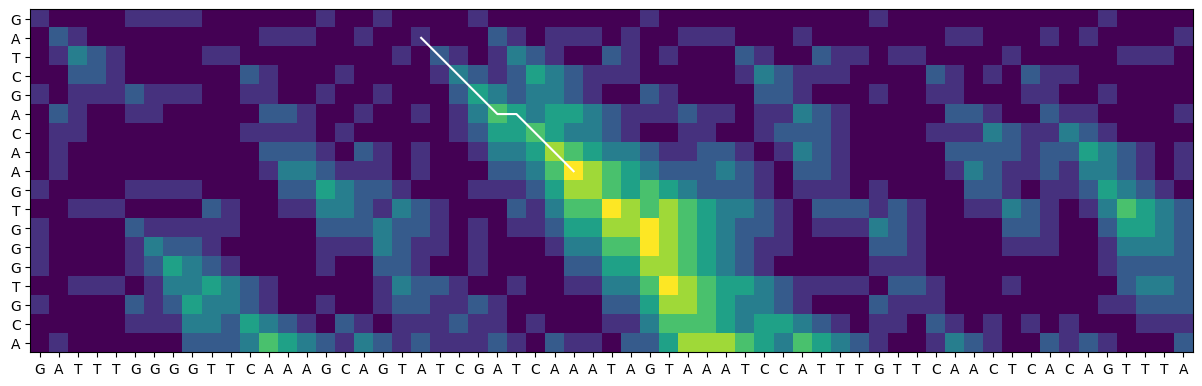

Multiple possible traceback starts: [ 9 33], [18 45]
Chose random traceback start from choices: [ 9 33]
Read                      : AATCAATAGGGACCTCTGA
Mapping position (0-based): 24
Aligned read              : ATC-AATAG
Aligned read w/o gaps     : ATCAATAG
Number of clipped bases   : 11
Reference subsequence     : ATCAAATAG


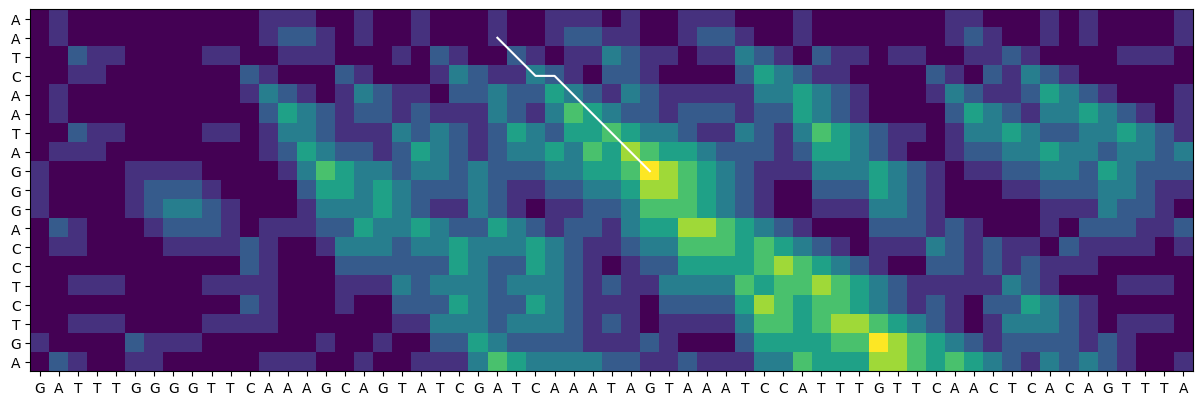

Read                      : GTAGTCGATGCTTTCGTTCAA
Mapping position (0-based): 30
Aligned read              : TAGTCGATGC-TTTCGTTCAA
Aligned read w/o gaps     : TAGTCGATGCTTTCGTTCAA
Number of clipped bases   : 1
Reference subsequence     : TAGTAAATCCATTTGTTCAA


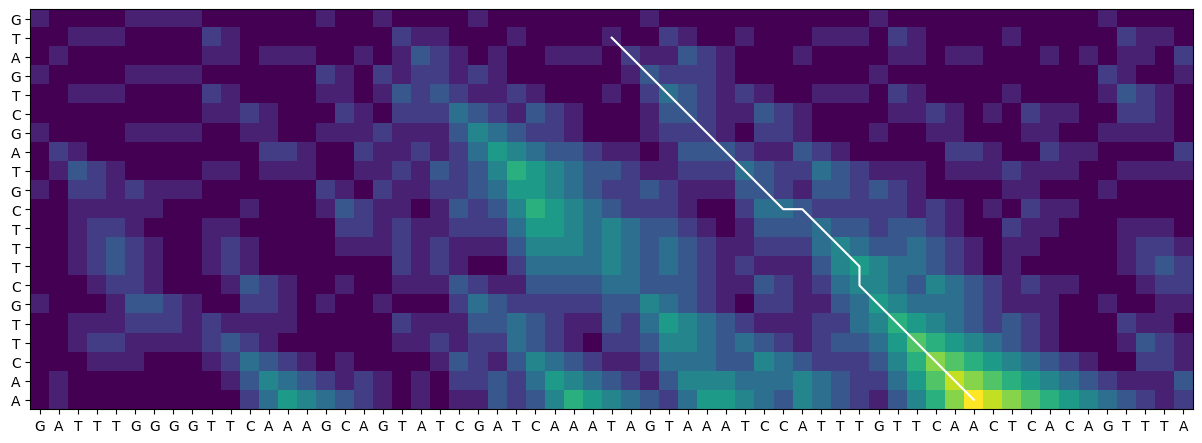

Multiple possible traceback starts: [20 29], [22 30], [23 32]
Chose random traceback start from choices: [23 32]
Read                      : TTGCAGAAGTGTTGATACAACAA
Mapping position (0-based): 9
Aligned read              : TTGCAGAAG-TGT-T-GATACAACA-A
Aligned read w/o gaps     : TTGCAGAAGTGTTGATACAACAA
Number of clipped bases   : 0
Reference subsequence     : TTCAAAGCAGTATCGATCAAATA


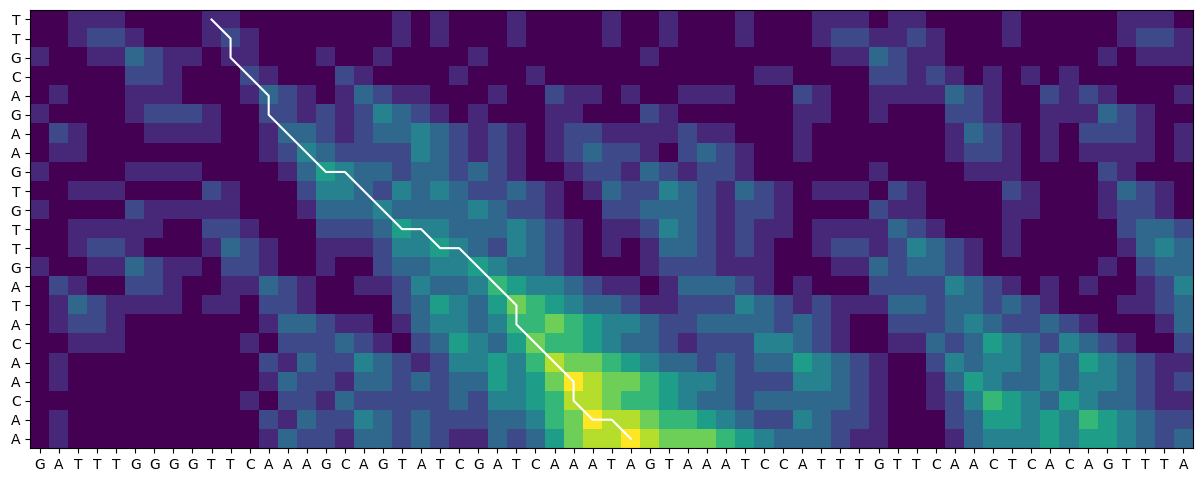

Read                      : AGATATTAAATACATA
Mapping position (0-based): 29
Aligned read              : ATATTAAATACAT
Aligned read w/o gaps     : ATATTAAATACAT
Number of clipped bases   : 3
Reference subsequence     : ATAGTAAATCCAT


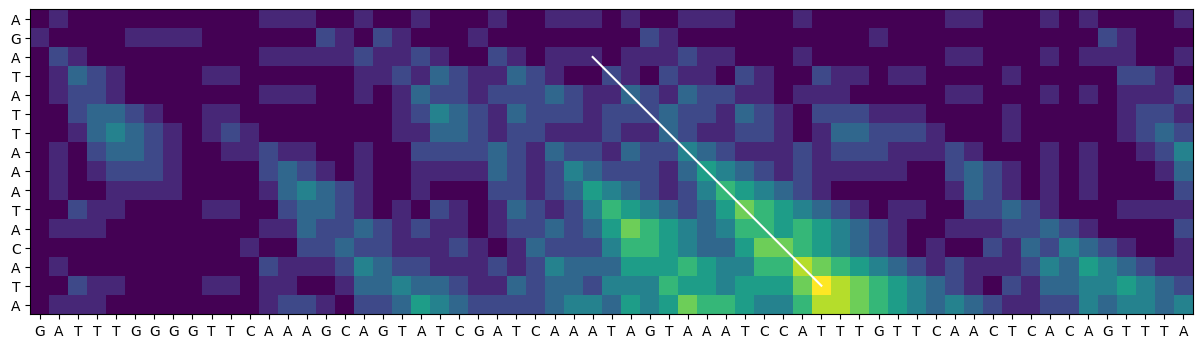

Multiple possible traceback starts: [15 48], [17 52], [19 53]
Chose random traceback start from choices: [15 48]
Read                      : ATAAATCCGTTGTTCCTTCT
Mapping position (0-based): 33
Aligned read              : TAAATCC-GTTGTTC
Aligned read w/o gaps     : TAAATCCGTTGTTC
Number of clipped bases   : 6
Reference subsequence     : TAAATCCATTTGTTC


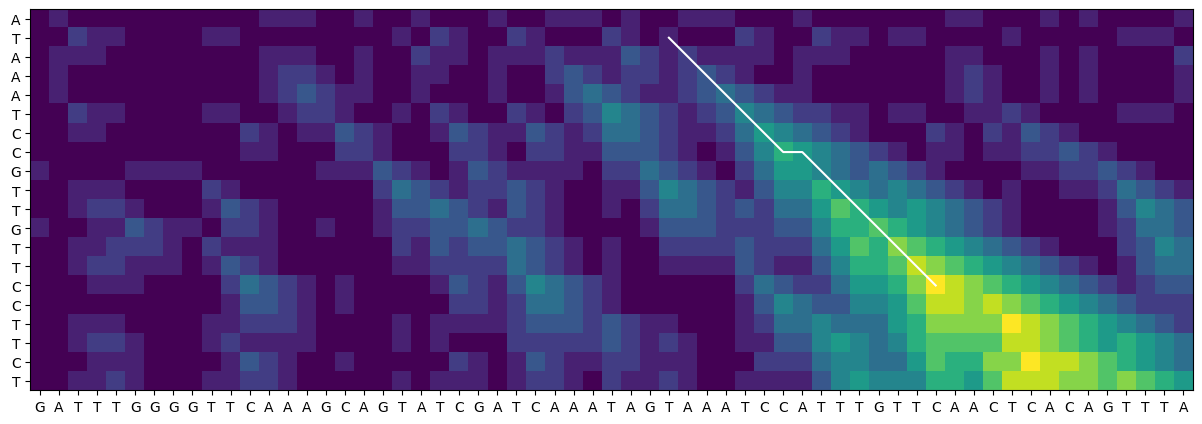

Multiple possible traceback starts: [14 31], [15 33], [17 34]
Chose random traceback start from choices: [15 33]
Read                      : AACATACACAAGATGCTT
Mapping position (0-based): 13
Aligned read              : AA-CA-TA-C-A-CAAGAT-G
Aligned read w/o gaps     : AACATACACAAGATG
Number of clipped bases   : 3
Reference subsequence     : AAGCAGTATCGATCAAATAG


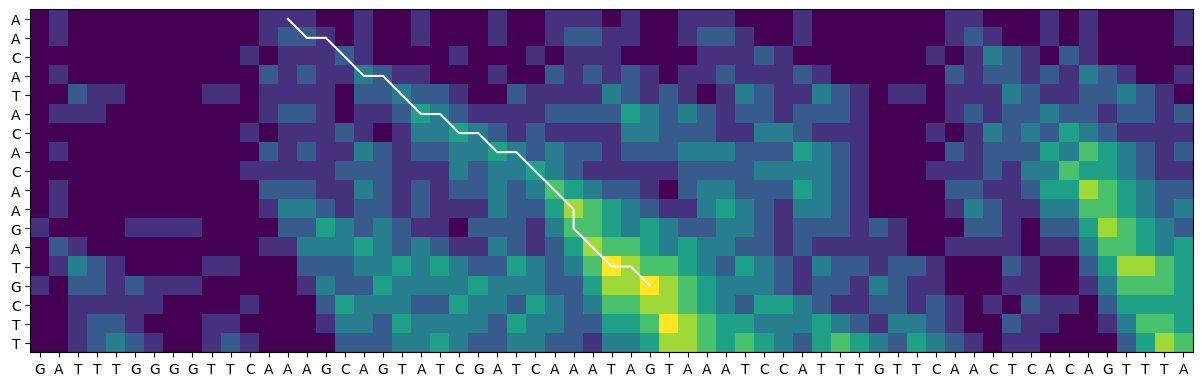

Read                      : TCAGCCGTATCGAACAA
Mapping position (0-based): 14
Aligned read              : AGCCGTATCGAACAA
Aligned read w/o gaps     : AGCCGTATCGAACAA
Number of clipped bases   : 2
Reference subsequence     : AGCAGTATCGATCAA


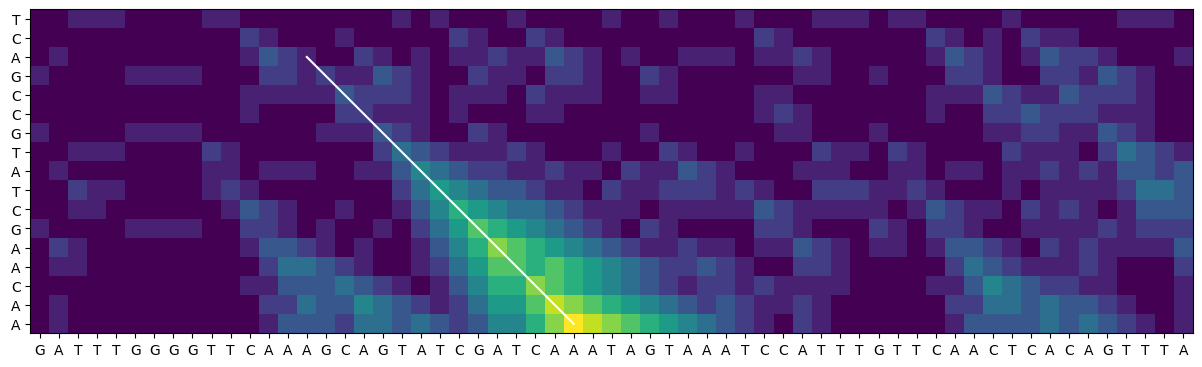

Read                      : AGAGTAAATCATTTGGTTAAGATCA
Mapping position (0-based): 31
Aligned read              : AGTAAAT-CATTTGGTT-AAGATCA
Aligned read w/o gaps     : AGTAAATCATTTGGTTAAGATCA
Number of clipped bases   : 2
Reference subsequence     : AGTAAATCCATTTGTTCAACTCA


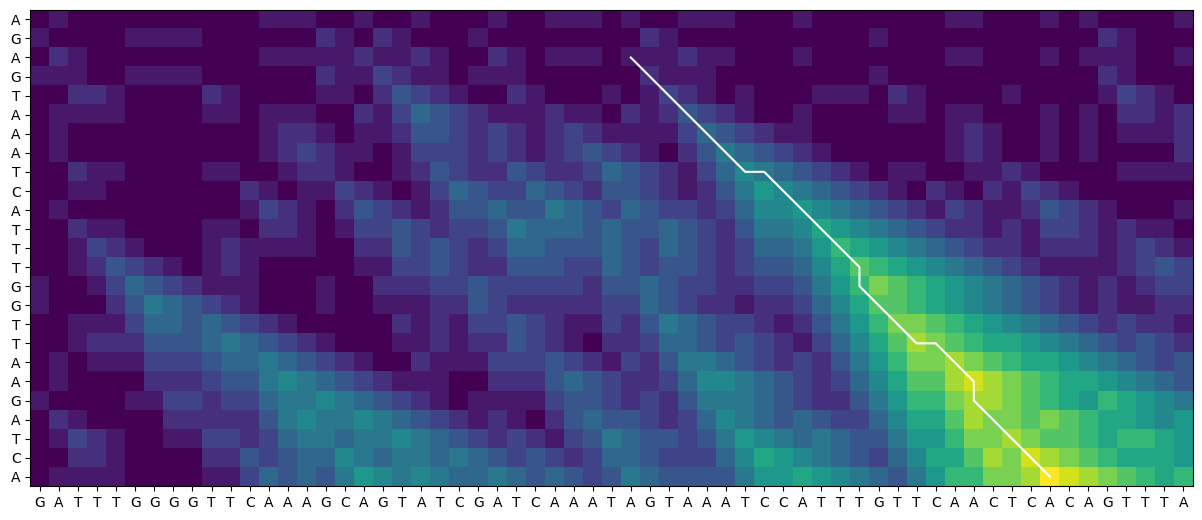

Multiple possible traceback starts: [15 29], [15 50]
Chose random traceback start from choices: [15 50]
Read                      : CAGCATTTCGCTTAA
Mapping position (0-based): 39
Aligned read              : CATTTCGCTT-AA
Aligned read w/o gaps     : CATTTCGCTTAA
Number of clipped bases   : 3
Reference subsequence     : CATTTGTTCAA


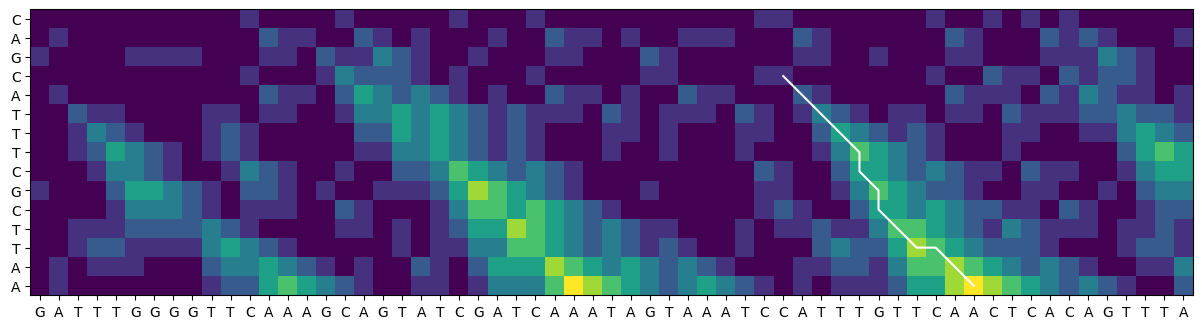

Read                      : TCATTGGGGTTTCCATCTAGTAG
Mapping position (0-based): 3
Aligned read              : TTGGGGTTTC-CATCTAGTA
Aligned read w/o gaps     : TTGGGGTTTCCATCTAGTA
Number of clipped bases   : 4
Reference subsequence     : TTGGGGTTCAAAGCAGTA


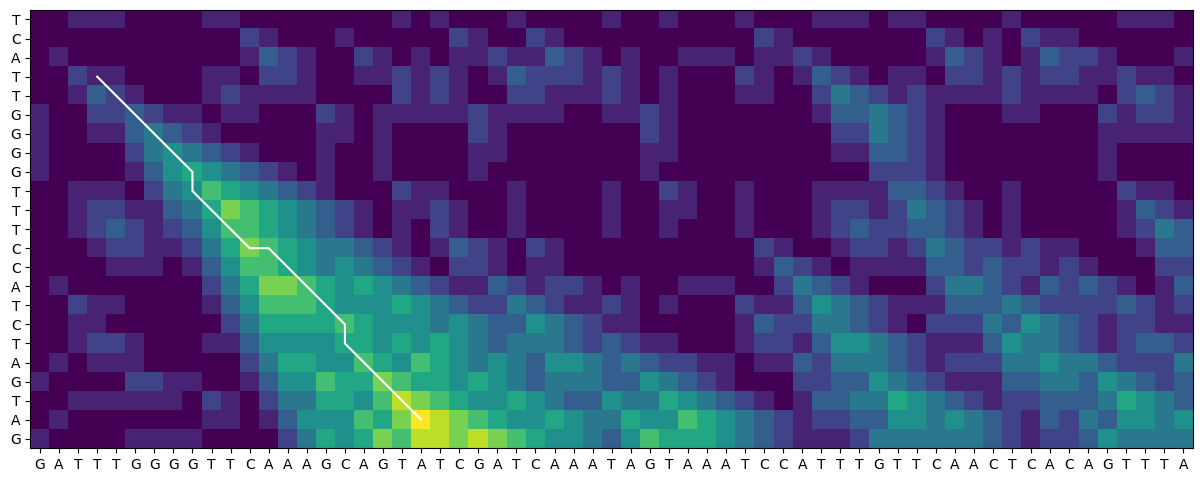

Read                      : TTCGATCAAGTGTGAAATTT
Mapping position (0-based): 21
Aligned read              : TCGATCAAGT-GTGAAAT
Aligned read w/o gaps     : TCGATCAAGTGTGAAAT
Number of clipped bases   : 3
Reference subsequence     : TCGATCAAATAGTAAAT


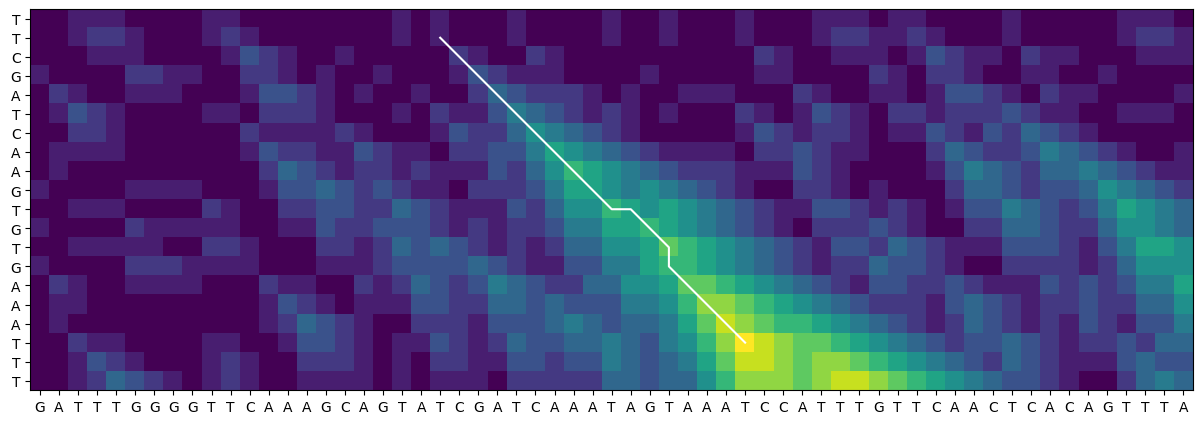

Read                      : CTACATCTGTTCGAATCACAGT
Mapping position (0-based): 39
Aligned read              : CATCTGTTCGAA-TCACAGT
Aligned read w/o gaps     : CATCTGTTCGAATCACAGT
Number of clipped bases   : 3
Reference subsequence     : CATTTGTTCAACTCACAGT


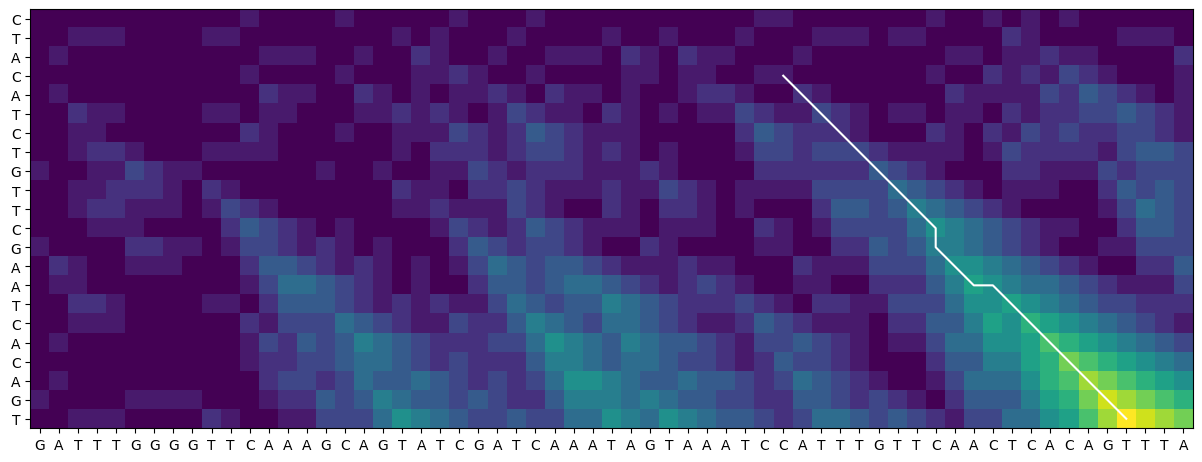

Read                      : AATAGGAAACGAATTTTTTACA
Mapping position (0-based): 28
Aligned read              : AATAGGAAA-CGAATTTTTTACA
Aligned read w/o gaps     : AATAGGAAACGAATTTTTTACA
Number of clipped bases   : 0
Reference subsequence     : AATAGTAAATCCATTTGTTCA


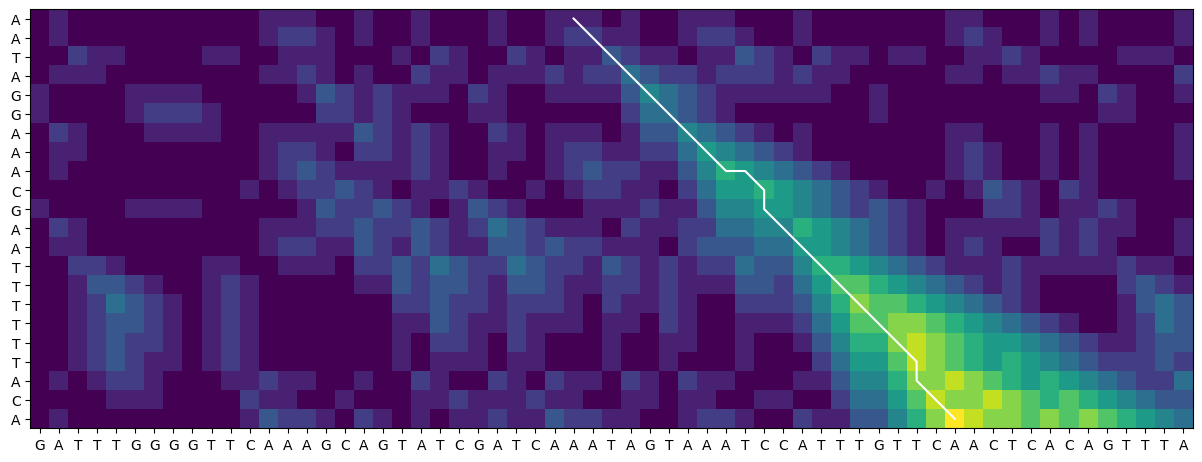

Multiple possible traceback starts: [14 34], [16 35], [16 36]
Chose random traceback start from choices: [16 36]
Read                      : ATAGATCAAATAGTGA
Mapping position (0-based): 20
Aligned read              : ATAGATCAAATAGTGA
Aligned read w/o gaps     : ATAGATCAAATAGTGA
Number of clipped bases   : 0
Reference subsequence     : ATCGATCAAATAGTAA


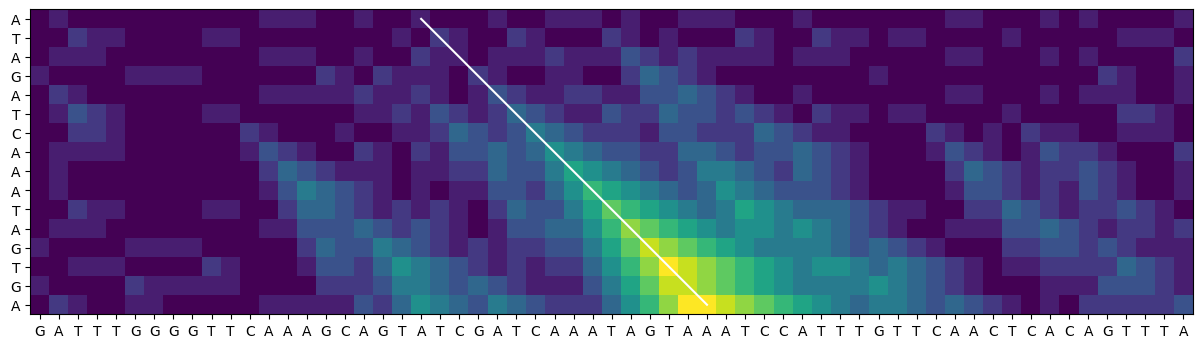

Read                      : CAAAGGTAATTGATCAT
Mapping position (0-based): 11
Aligned read              : CAAAG--GTAATTGATCA
Aligned read w/o gaps     : CAAAGGTAATTGATCA
Number of clipped bases   : 1
Reference subsequence     : CAAAGCAGTATCGATCA


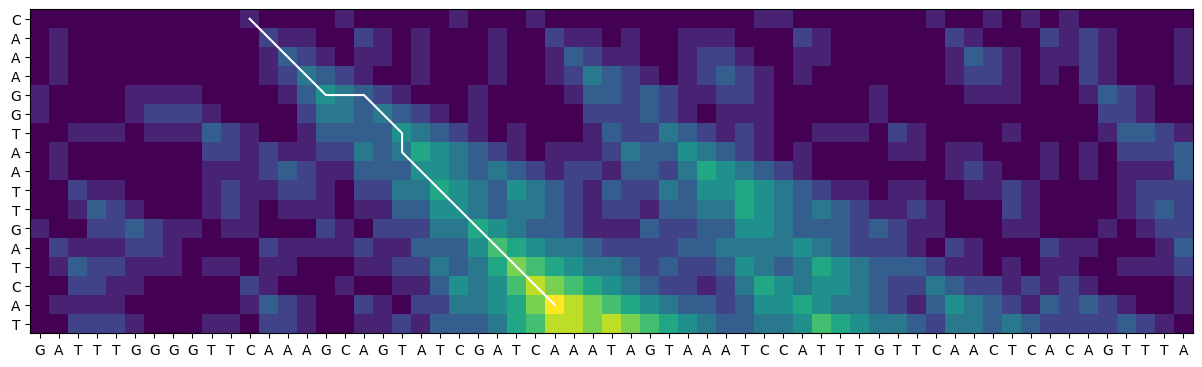

Multiple possible traceback starts: [15 15], [16 17]
Chose random traceback start from choices: [15 15]
Read                      : CAGTTGGAGTTCAAAC
Mapping position (0-based): 3
Aligned read              : TTGGAGTTCAAA
Aligned read w/o gaps     : TTGGAGTTCAAA
Number of clipped bases   : 4
Reference subsequence     : TTGGGGTTCAAA


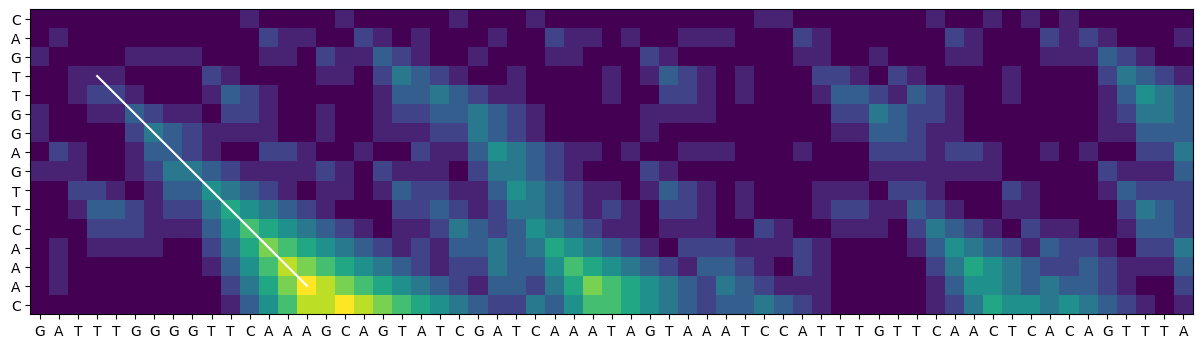

Read                      : TTTGGCGATCATTGCAGTATTGATT
Mapping position (0-based): 2
Aligned read              : TTTGGCGATCATTGCAGTATTGAT
Aligned read w/o gaps     : TTTGGCGATCATTGCAGTATTGAT
Number of clipped bases   : 1
Reference subsequence     : TTTGGGGTTCAAAGCAGTATCGAT


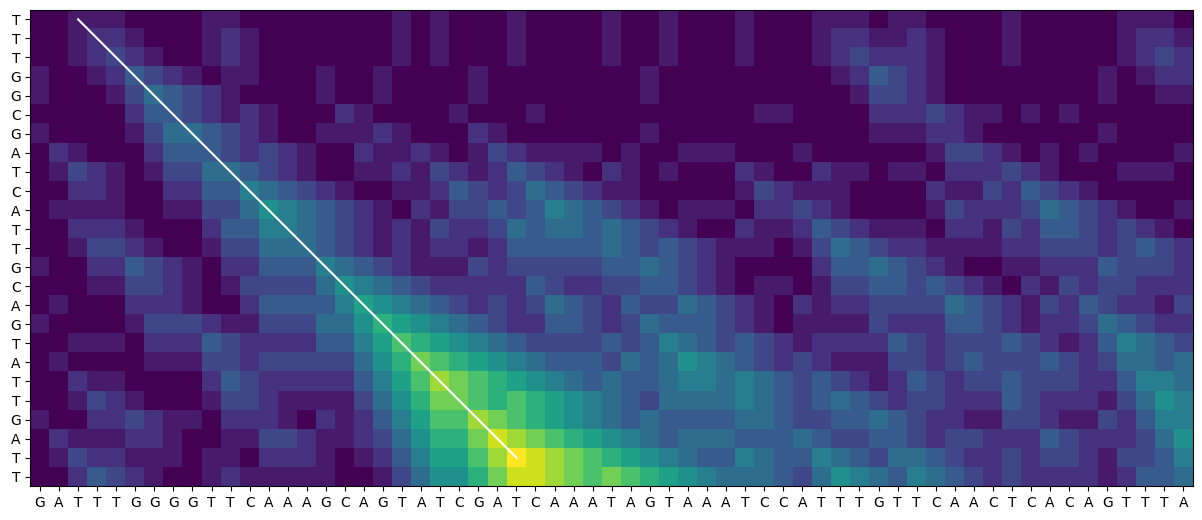

In [15]:
mapping_positions = []
aligned_reads = []

for read in noisy_reads:
    align = aln.make_align(mode="local")
    read_aln, ref_aln, warp_path_read, warp_path_ref, scoring_mat = align(
        seq_a=read, seq_b=reference_sequence
    )

    mapping_position = warp_path_ref[0]
    aligned_read = "".join(read_aln)
    mapping_positions.append(mapping_position)
    aligned_reads.append(aligned_read)

    print(f"Read                      : {read}")
    print(f"Mapping position (0-based): {mapping_position}")
    print(f"Aligned read              : {aligned_read}")
    aligned_read_without_gaps = list(filter(lambda elem: elem != "-", read_aln))
    print(f"Aligned read w/o gaps     : {''.join(aligned_read_without_gaps)}")
    print(f"Number of clipped bases   : {len(read) - len(aligned_read_without_gaps)}")
    print(
        f"Reference subsequence     : "
        f"{reference_sequence[warp_path_ref[0] : (warp_path_ref[-1] + 1)]}"
    )

    plt.figure(figsize=(15, 8))
    plt.imshow(X=scoring_mat)
    plt.plot(warp_path_ref, warp_path_read, "w")
    plt.xticks(ticks=range(len(reference_sequence)), labels=reference_sequence)
    plt.yticks(ticks=range(len(read)), labels=read)
    plt.show()

We now have the following set of aligned reads:

In [16]:
print(f"Reference: {reference_sequence}")
for i, (pos, seq) in enumerate(zip(mapping_positions, aligned_reads)):
    print(f"Read {i:4}: {' ' * pos}{seq}")

Reference: GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA
Read    0:                             AATAAGTAAAGC
Read    1:                         ATCAAGGGAGTAGTAAA-C
Read    2:                     ATCGA-CAA
Read    3:                         ATC-AATAG
Read    4:                               TAGTCGATGC-TTTCGTTCAA
Read    5:          TTGCAGAAG-TGT-T-GATACAACA-A
Read    6:                              ATATTAAATACAT
Read    7:                                  TAAATCC-GTTGTTC
Read    8:              AA-CA-TA-C-A-CAAGAT-G
Read    9:               AGCCGTATCGAACAA
Read   10:                                AGTAAAT-CATTTGGTT-AAGATCA
Read   11:                                        CATTTCGCTT-AA
Read   12:    TTGGGGTTTC-CATCTAGTA
Read   13:                      TCGATCAAGT-GTGAAAT
Read   14:                                        CATCTGTTCGAA-TCACAGT
Read   15:                             AATAGGAAA-CGAATTTTTTACA
Read   16:                     ATAGATCAAATAGTGA
Read   17:            

# Variant Calling

Variant calling is a crucial step in analyzing DNA sequence data to identify differences or variations in the genetic code of individuals.
This process involves comparing an individual's DNA sequence (in the form of aligned reads) to a reference sequence to pinpoint variations such as single nucleotide polymorphisms (SNPs), insertions, deletions, and structural alterations.

While there exist many sophisticated variant calling algorithms such as [GATK](https://gatk.broadinstitute.org)'s [HaplotypeCaller](https://gatk.broadinstitute.org/hc/en-us/articles/360037225632-HaplotypeCaller), we will here focus on SNPs only and perform a simple majority voting per locus.

##### ❓ SNP calling via majority vote

Complete the following code to call SNPs via majority voting.

In [17]:
from collections import Counter

pileups = [[] for _ in range(len(reference_sequence))]
snps = {}

# Accumulate the pileups.
for pos, seq in zip(mapping_positions, aligned_reads):
    for offset, _ in enumerate(seq):
        # It may happen that an aligned read extends beyond the reference sequence.
        # We decided not to generate additional pileups, and hence, we will just ignore
        # the overhanging bases.
        pileup_index = pos + offset
        if pileup_index < len(reference_sequence):
            pileups[pileup_index].append(seq[offset])

# SNP calling via majority voting.
print("POS   REF   MAJ   SNP   PILEUP")
for i, pileup in enumerate(pileups):
    majority_base = ""
    snp = "-"

    # Make a pileup string.
    pileup = "".join(pileup)

    # We can only call variants for non-empty pileups.
    if pileup:
        # Count the occurrences of each character in the pileup.
        char_counts = Counter(pileup)
        # Find the most common character.
        majority_base, _ = char_counts.most_common(n=1)[0]
    # No variant if the pileup is empty.
    else:
        majority_base = "-"

    # Call it if it's a SNP.
    if majority_base != "-" and majority_base != reference_sequence[i]:
        snp = majority_base
        snps[i] = snp

    print(f"{i:3}   {reference_sequence[i]:3}   {majority_base:3}   {snp:3}   {pileup}")

POS   REF   MAJ   SNP   PILEUP
  0   G     -     -     
  1   A     -     -     
  2   T     T     -     T
  3   T     T     -     TTT
  4   T     T     -     TTT
  5   G     G     -     GGG
  6   G     G     -     GGG
  7   G     G     -     GAC
  8   G     G     -     GGG
  9   T     T     -     TTTA
 10   T     T     -     TTTT
 11   C     C     -     GTCCC
 12   A     A     -     CCAAA
 13   A     A     -     AA-AAT
 14   A     A     -     GAACAAT
 15   G     G     -     A-GAGG
 16   C     C     -     ACCT-C
 17   A     A     -     GACC-A
 18   G     G     -     --GTGG
 19   T     T     -     TTTATT
 20   A     A     -     AGAAGAAA
 21   T     T     -     TT-TTTTAT
 22   C     C     -     C-CCACATT
 23   G     G     -     GT-GGGTG
 24   A     A     -     AAA-AAAAGA
 25   T     T     -     T-TG-ATTAT
 26   C     C     -     CCCACCCCT
 27   A     A     -     AA-TAAAAC
 28   A     A     -     AAAAAAAAAAA
 29   A     A     -     AGACAGGAA
 30   T     T     -     TGTTATATTT
 31   A     

In [18]:
# List all SNPs.
print("POS   SNP")
for pos, snp in snps.items():
    print(f"{pos:3}   {snp:3}")

POS   SNP
 38   G  
 45   G  
 47   T  
 48   C  
 50   A  
 51   G  
 52   A  
 53   T  
 56   A  
 57   G  
